In [401]:
import numpy as np
import cvxpy as cp
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [402]:
%cd /content/drive/MyDrive/ORF363 PS

/content/drive/MyDrive/ORF363 PS


# Question 1


--- Solving for Plan 1: Maximize CES ---
Problem Status: optimal
Optimal CES: 14.766908
CES for Group 1: 14.766908
CES for Group 2: -4.715369
CES for Group 3: 15.166979

--- Solving for Plan 2: Maximize CES ---
Problem Status: optimal
Optimal CES: 12.574318
CES for Group 1: -1.054779
CES for Group 2: 12.574318
CES for Group 3: -6.500134

--- Solving for Plan 3: Maximize CES ---
Problem Status: optimal
Optimal CES: 15.166980
CES for Group 1: 14.766908
CES for Group 2: -4.715369
CES for Group 3: 15.166980


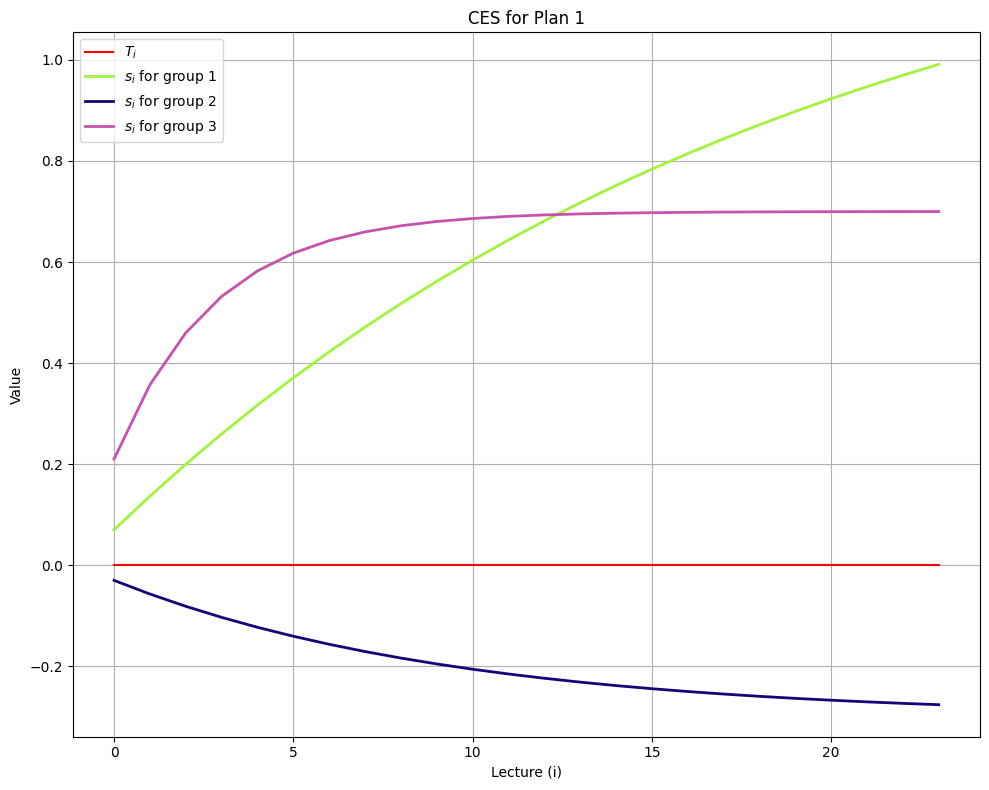

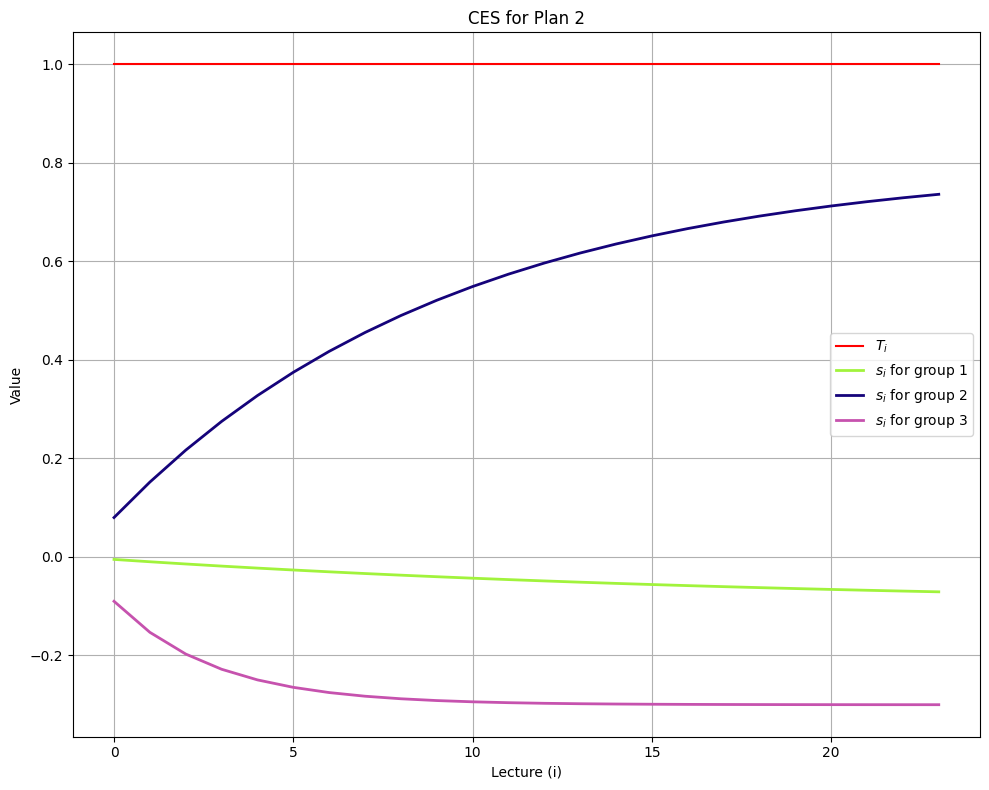

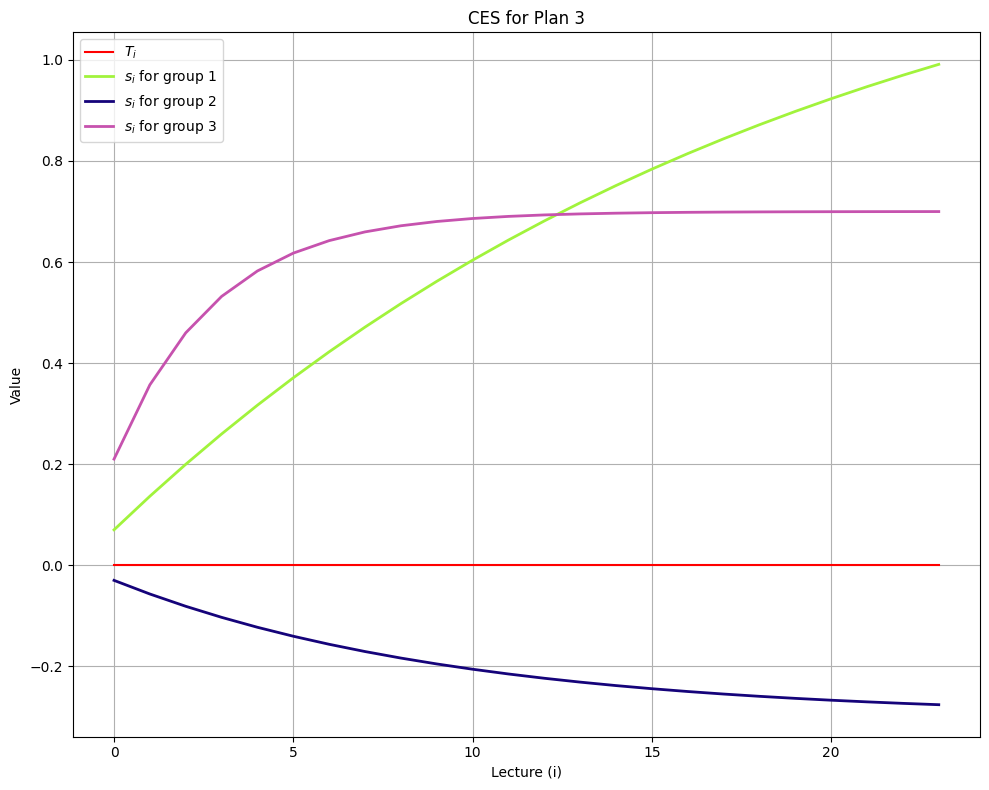

In [403]:
n = 24
a = 2
b = 3

theta = [0.05, 0.1, 0.3]
alpha = [-0.1, 0.8, -0.3]
beta = [1.4, -0.3, 0.7]
s_init = 0


for p in range(1,4):
  T = cp.Variable(n, nonneg=True)
  A = cp.Variable(n, nonneg=True)
  U = cp.Variable(n)
  s = cp.Variable(n+1)

  constraints = [
      A + T == 1,
      U >= T - b,
      U >= 0,
      A <= a * U,

      # calculation of s_i
      s[0] == s_init,
      s[1:] == (1 - theta[p-1]) * s[:-1] + theta[p-1] * (alpha[p-1] * T + beta[p-1] * A)
  ]

  # objective function
  ces_obj = cp.sum(s[1:])

  # solve
  problem = cp.Problem(cp.Maximize(ces_obj), constraints)
  problem.solve()

  print(f"\n--- Solving for Plan {p}: Maximize CES ---")
  print(f"Problem Status: {problem.status}")
  print(f"Optimal CES: {problem.value:.6f}")

  colors = ["#A1F33C","#15037A", "#C652AE"]

  T_val = T.value
  A_val = A.value


  plt.figure(figsize=(10,8))
  plt.plot(T_val, label="$T_i$", color='#ff0000')

  ces_all = []

  for g in range(3):
    theta_g = theta[g]
    alpha_g = alpha[g]
    beta_g = beta[g]
    s_g = np.empty(n+1, dtype=float)
    s_g[0] = s_init

    for j in range(n):
      s_g[j+1] = (1- theta_g) * s_g[j] + theta_g * (alpha_g * T_val[j] + beta_g * A_val[j])

    ces_all.append(np.sum(s_g[1:]))
    plt.plot(s_g[1:], label=f"$s_i$ for group {g + 1}", color=colors[g], linewidth=2)
    print(f"CES for Group {g+1}: {ces_all[g]:.6f}")

  plt.xlabel("Lecture (i)")
  plt.ylabel("Value")
  plt.title(f"CES for Plan {p}")
  plt.legend(loc='best')
  plt.grid(True)
  plt.tight_layout()



Problem Status: optimal
Optimal minimum CES: 4.9813

     Cumulative Emotional State (CES) Results
Grouup 1 CES using MaxMin: 5.188371
Grouup 2 CES using MaxMin: 4.981273
Grouup 3 CES using MaxMin: 4.981273


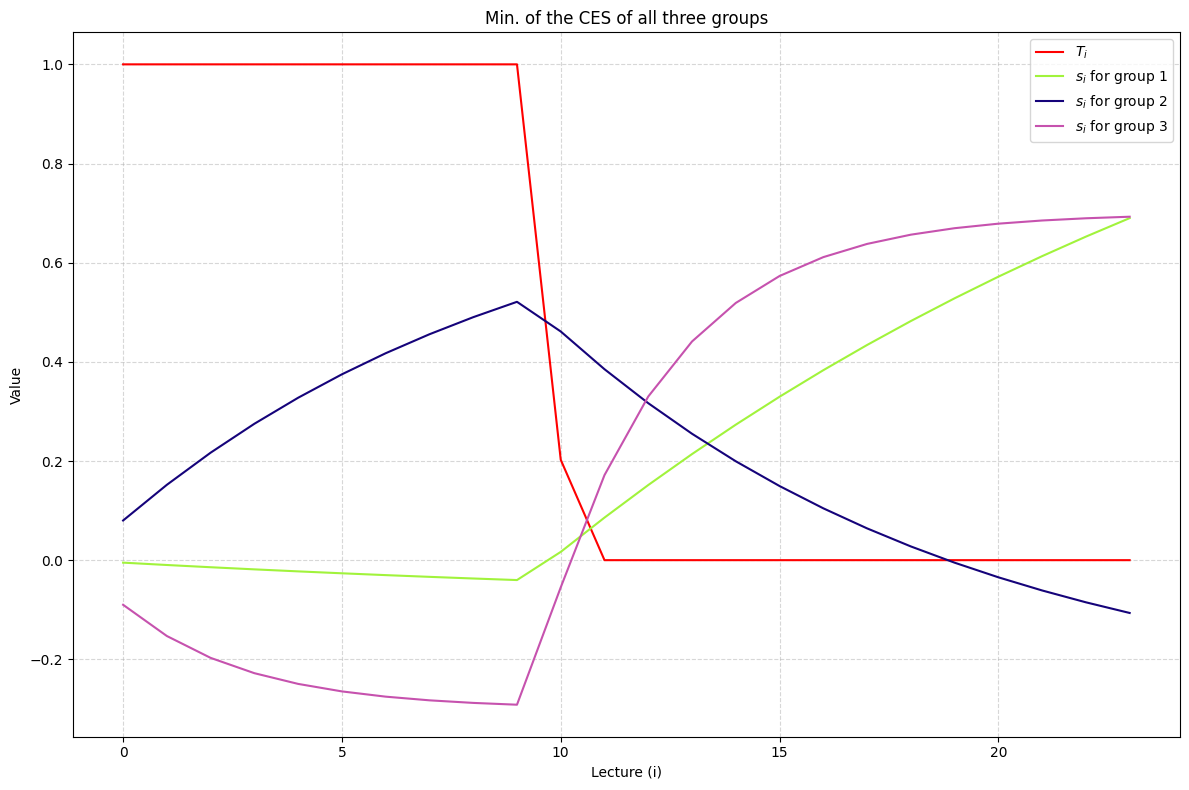

In [404]:
# Maximizing the minimum of the CES for all 3 Groups
A = cp.Variable(n, nonneg=True)
T = cp.Variable(n, nonneg=True)
U = cp.Variable(n)
sg1 = cp.Variable(n+1)
sg2 = cp.Variable(n+1)
sg3 = cp.Variable(n+1)
t = cp.Variable()


constraints = [
    A + T == 1,
    U >= T - b,
    U >= 0,
    A <= a * U,
    # compute the s_i for each group
    sg1[0] == s_init,
    sg1[1:] == (1 - theta[0]) * sg1[:-1] + theta[0] * (alpha[0] * T + beta[0] * A),

    sg2[0] == s_init,
    sg2[1:] == (1 - theta[1]) * sg2[:-1] + theta[1] * (alpha[1] * T + beta[1] * A),

    sg3[0] == s_init,
    sg3[1:] == (1 - theta[2]) * sg3[:-1] + theta[2] * (alpha[2] * T + beta[2] * A),

    # The variable t will hold the minimum of the 3 CESs
    t <= cp.sum(sg1[1:]),
    t <= cp.sum(sg2[1:]),
    t <= cp.sum(sg3[1:])

]

# Implementing the new objective of maximizing t
objective = cp.Maximize(t)
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()
print(f"Problem Status: {problem.status}")
print(f"Optimal minimum CES: {problem.value:.4f}")


# Get the optimal T vector and s vectors
T_val = T.value
sg1_val = sg1.value
sg2_val = sg2.value
sg3_val = sg3.value

ces_all = [cp.sum(sg1[1:]).value, cp.sum(sg2[1:]).value, cp.sum(sg3[1:]).value]
sg_vec_val = [sg1_val, sg2_val, sg3_val]


# Reporting results
print("\n" + "="*50)
print("     Cumulative Emotional State (CES) Results")
print("="*50)

plt.figure(figsize=(12,8))
plt.plot(T_val, label="$T_i$", color='#ff0000')


for g in range(3):
  print(f"Grouup {g+1} CES using MaxMin: {ces_all[g]:.6f}")
  plt.plot(sg_vec_val[g][1:], label=f"$s_i$ for group {g+1}", color=colors[g])
  plt.legend(loc="best")

plt.xlabel("Lecture (i)")
plt.ylabel("Value")
plt.title("Min. of the CES of all three groups")
plt.grid(True, linestyle="--",alpha=0.5)
plt.tight_layout()

# Question 3

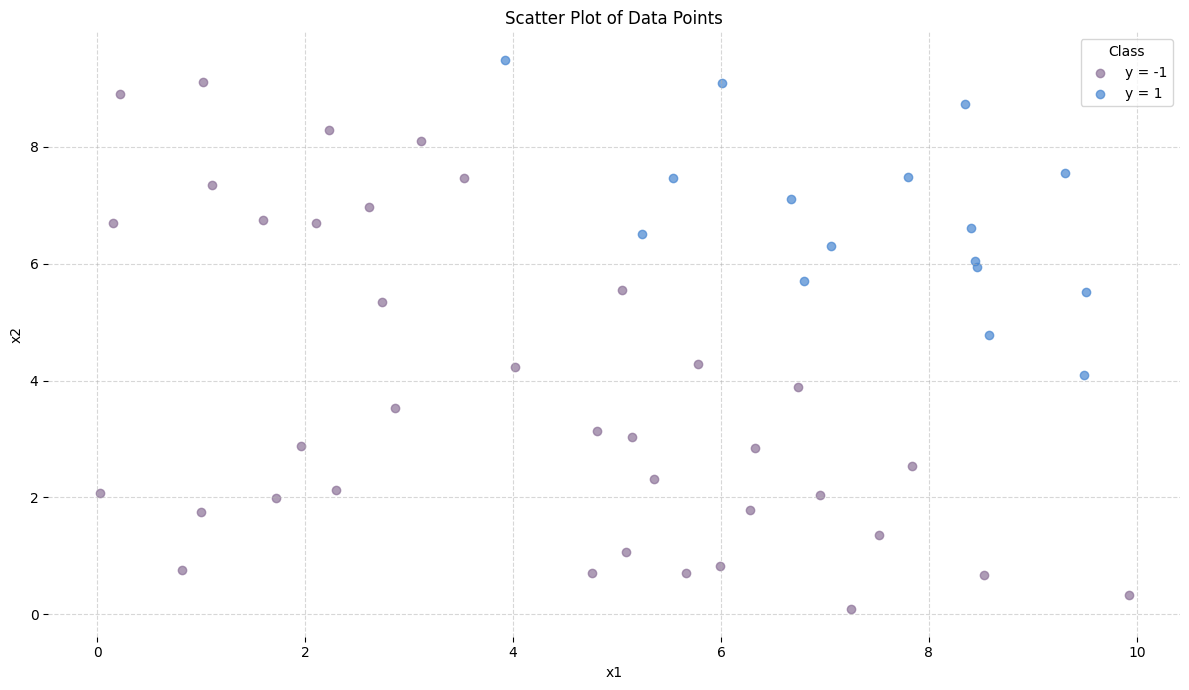

In [405]:
mat = scipy.io.loadmat("HWSVM.mat")
x1 = mat['x1part2'].ravel()
x2 = mat['x2part2'].ravel()
y = mat['ypart2'].ravel()

X = np.column_stack((x1, x2))
y = y.flatten()

N, d = X.shape
a = cp.Variable(d)
b = cp.Variable()
constraints = [cp.multiply(y, X @ a - b) >= 1]
objective = cp.norm(a, p=2)
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve()

colors = ['#8C7298', '#4786D1']
unique_labels = np.unique(y)
color_map = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots(figsize=(12, 7))
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for label, color in color_map.items():
  color_loc = (y==label)

  ax.scatter(x1[color_loc],
             x2[color_loc],
             c=color,
             label=f'y = {label}',
             alpha=0.7)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Scatter Plot of Data Points")
ax.legend(title="Class")
ax.grid(True, linestyle="--",alpha=0.5)
plt.tight_layout()


/tmp/ipython-input-3422677806.py:61: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


Text(0.5, 1.0, 'Scatter Plot of Data Points')

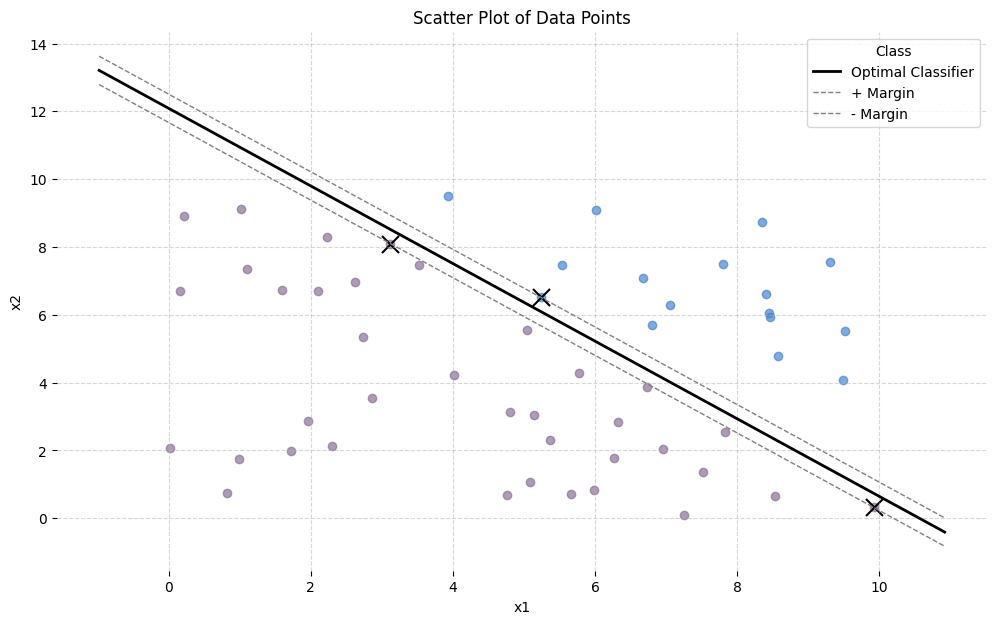

In [406]:
fig,ax = plt.subplots(figsize=(12,7))

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)



def get_hyperplane_x2(x1, a, b, offset):
  """ Calculates x2 for a given x1 on a hyperplane."""
  return (-a[0] * x1 + b + offset) / a[1]


plot_x1 = np.linspace(np.min(X[:,0]) - 1, np.max(X[:,0]) + 1, 53)
x2_classifier = get_hyperplane_x2(plot_x1, a.value, b.value, 0)
x2_margin_pos = get_hyperplane_x2(plot_x1, a.value, b.value, 1)
x2_margin_neg = get_hyperplane_x2(plot_x1, a.value, b.value, -1)

# Plot the hyperplanes
ax.plot(
    plot_x1,
    x2_classifier,
    'k-',
    linewidth=2,
    label="Optimal Classifier"
)

ax.plot(
    plot_x1,
    x2_margin_pos,
    linewidth=1,
    c='gray',
    label="+ Margin",
    linestyle='--'
)

ax.plot(
    plot_x1,
    x2_margin_neg,
    linewidth=1,
    linestyle='--',
    c='gray',
    label='- Margin'
)

ax.legend(title="Class")
ax.grid(True, linestyle="--",alpha=0.5)

for label, color in color_map.items():
  color_loc = (y==label)

  ax.scatter(x1[color_loc],
             x2[color_loc],
             c=color,
             label=f'Label {label}',
             alpha=0.7)


# #Plot the support vectors
ax.scatter(
    support_vectors[:,0],
    support_vectors[:,1],
    s=150,
    facecolors='none',
    edgecolors='k',
    c='black',
    marker='x',
    label='Support Vectors'
)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Scatter Plot of Data Points")

In [407]:
alpha = constraints[0].dual_value
tolerance = 1e-5
sv_idx = np.where(alpha > tolerance)[0]
support_vectors = X[sv_idx]
sv_label = y[sv_idx]

for (x1, x2), y in zip(support_vectors, sv_label):
  print(f"Support Vector: ({x1:.6f}, {x2:.6f}) with label {y}")


Support Vector: (9.921000, 0.320500) with label -1
Support Vector: (5.239700, 6.512100) with label 1
Support Vector: (3.118000, 8.103200) with label -1


In [408]:
print("="*80)
print("     Equations for Hyperplanes")
print("="*80)
print(f"Decision boundary: {a.value[0]}x1 + {a.value[1]}x2 - {b.value} = 0")
print(f"Positive Margin: {a.value[0]}x1 + {a.value[1]}x2 - {b.value + 1} = 0")
print(f"Negative Margin: {a.value[0]}x1 + {a.value[1]}x2 - {b.value - 1} = 0")

     Equations for Hyperplanes
Decision boundary: 2.736388110028493x1 + 2.391926750692393x2 - 28.914318973612033 = 0
Positive Margin: 2.736388110028493x1 + 2.391926750692393x2 - 29.914318973612033 = 0
Negative Margin: 2.736388110028493x1 + 2.391926750692393x2 - 27.914318973612033 = 0


#Question 4

The point shared by conv(A) & conv(B) is (6.158467, 4.312470)


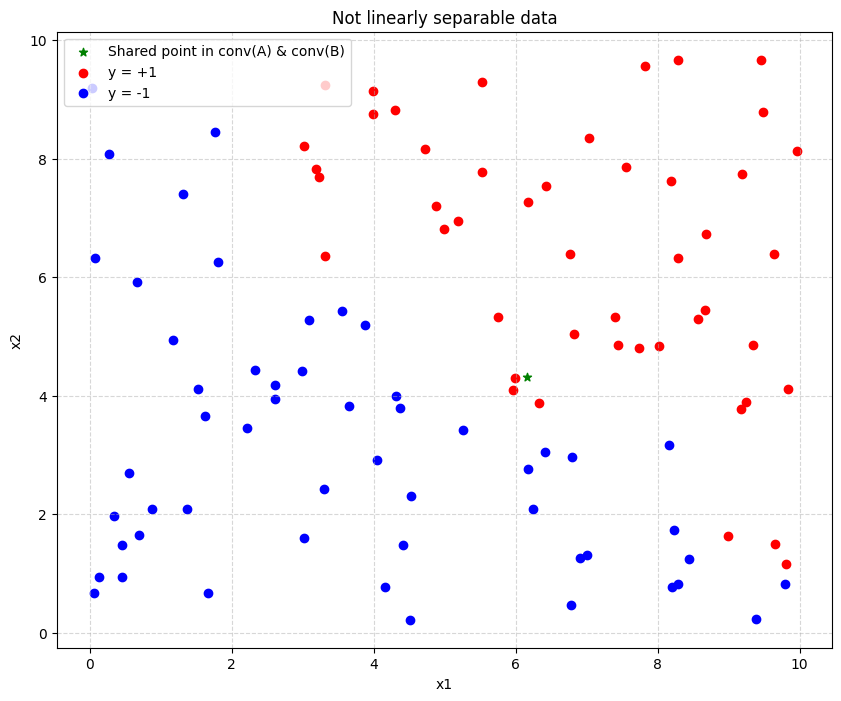

In [409]:
del constraints
x1 = mat["x1part3"].ravel()
x2 = mat["x2part3"].ravel()
y = mat["ypart3"].ravel()

# Section computing the shared point in convex hull

set_a = np.vstack([x1[y == 1], x2[y == 1]])
set_b = np.vstack([x1[y == -1], x2[y == -1]])

k = set_a.shape[1]
j = set_b.shape[1]

# decision variables
u = cp.Variable(k)
v = cp.Variable(j)

constraints = [
    u >= 0,
    v >= 0,
    cp.sum(u) == 1,
    cp.sum(v) == 1
]

# objective function
problem = cp.Problem(cp.Minimize(cp.norm(set_a @ u - set_b @ v)), constraints)
opt_val = problem.solve()
shared_pt = (set_a @ u).value


plt.figure(figsize=(10,8))

if (opt_val <= 1e-9):
  plt.scatter(shared_pt[0], shared_pt[1], marker="*", color='green', label="Shared point in conv(A) & conv(B)")
  print(f"The point shared by conv(A) & conv(B) is ({shared_pt[0]:.6f}, {shared_pt[1]:.6f})")

plt.scatter(x1[y==1], x2[y==1], marker='o', color='red', label='y = +1')
plt.scatter(x1[y==-1], x2[y==-1], marker='o', color='blue',label='y = -1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Not linearly separable data')
plt.legend(loc="best")
plt.grid(True, linestyle="--",alpha=0.5)
plt.show()

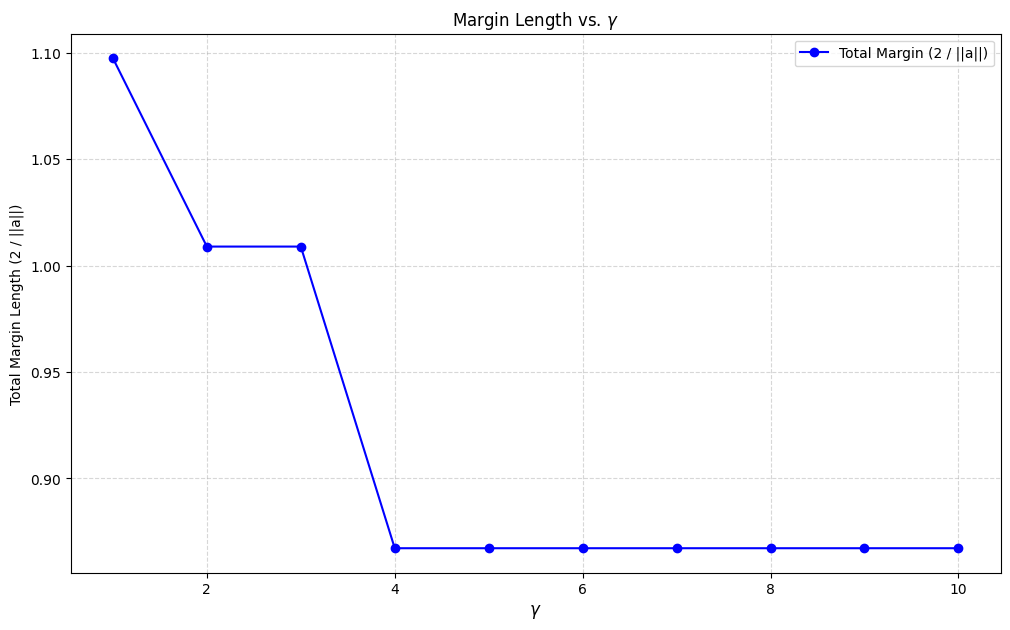

In [410]:
a = cp.Variable(2)
b = cp.Variable()
m = x1.flatten().shape[0]
eta = cp.Variable(m)
gammas = np.arange(1,11)

X = np.column_stack((x1, x2))
y = y.flatten()

constraints = [
    eta >= 0,
    cp.multiply(y, X @ a - b) >= 1 - eta
]

# matrices to store optimal values
opt_a = np.zeros((a.shape[0], len(gammas)))
opt_b = np.zeros(len(gammas))
opt_val = np.zeros(len(gammas))

margins = np.zeros(len(gammas))
misclassified_cts = np.zeros(len(gammas), dtype=int)

for i, gamma in enumerate(gammas):
  objective = cp.norm(a, p=2) + gamma * cp.norm(eta, p=1)
  prob = cp.Problem(cp.Minimize(objective), constraints)
  prob.solve()

  opt_val[i] = prob.value
  opt_a[:, i] = a.value
  opt_b[i] = b.value

  norm_a = np.linalg.norm(a.value, ord=2)
  margins[i] = 2 / norm_a

  scores = y * (X @ a.value - b.value)
  misclassified_cts[i] = int(np.sum(scores < 0))

plt.figure(figsize=(12,7))
plt.plot(gammas, margins, 'bo-', label='Total Margin (2 / ||a||)')
plt.xlabel("$\\gamma$", fontsize=12)
plt.ylabel("Total Margin Length (2 / ||a||)")
plt.title("Margin Length vs. $\\gamma$")
plt.grid(True, linestyle="--",alpha=0.5)
plt.legend()

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-760270269.py:5: SyntaxWarning: invalid escape sequence '\g'
  plt.title("Number of Misclassified Points vs. $\gamma$")


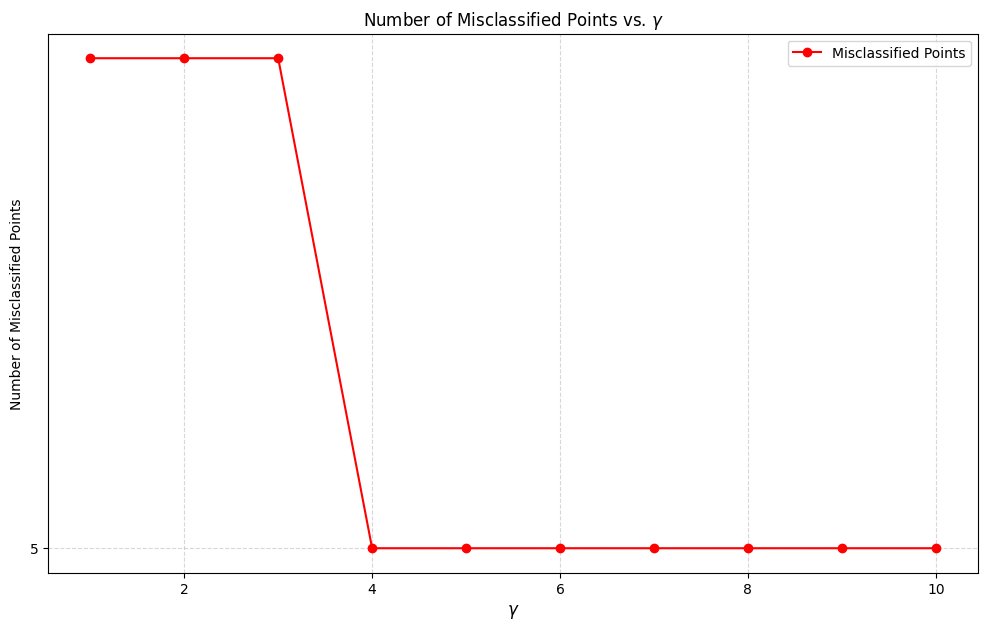

In [411]:
plt.figure(figsize=(12,7))
plt.plot(gammas, misclassified_cts, 'ro-', label='Misclassified Points')
plt.xlabel("$\\gamma$", fontsize=12)
plt.ylabel("Number of Misclassified Points")
plt.title("Number of Misclassified Points vs. $\gamma$")
plt.yticks(np.arange(min(misclassified_cts), max(misclassified_cts)))
plt.grid(True, linestyle="--",alpha=0.5)
plt.legend()


# Question 5

In [412]:
del constraints
del objective
del prob

dat = scipy.io.loadmat("Hillary_vs_Bernie.mat")
features_test = dat["features_test"]
features_train = dat["features_train"]
labels_test = dat["labels_test"].squeeze()
labels_train = dat["labels_train"].squeeze()

N, d = features_train.shape
gammas = [0.1,1,10]

opt_val = np.zeros(3)
opt_a = np.zeros((d,3))
opt_b = np.zeros(3)


for i in range(len(gammas)):
  a = cp.Variable(d)
  b = cp.Variable()
  eta = cp.Variable(N)

  objective = cp.norm(a, p=2) + gammas[i] * cp.norm(eta,p=1)
  constraints = [cp.multiply(labels_train, features_train @ a - b) >= 1 - eta,
               eta >= 0]
  prob = cp.Problem(cp.Minimize(objective), constraints)
  prob.solve()

  print(f"For gamma = {gammas[i]}")
  opt_val[i] = prob.value
  opt_a[:, i] = a.value
  opt_b[i] = b.value
  print(f"Optimal value: {prob.value}")
  print(f"Optimal a: {a.value}")
  print(f"Optimal b: {b.value}\n")




For gamma = 0.1
Optimal value: 10.572696685225385
Optimal a: [ 0.14105234  0.18277616 -0.73224995 -0.10977292  0.38083909]
Optimal b: -3.147002541871367

For gamma = 1
Optimal value: 89.43653660476755
Optimal a: [ 0.20864822 -0.97870147 -1.62007281 -0.4604091   3.76855069]
Optimal b: -9.24105062768508

For gamma = 10
Optimal value: 852.4305778901796
Optimal a: [ 0.15062914 -0.91314802 -1.52389243 -0.4642144   4.82133806]
Optimal b: -8.804717210428535



###Part B

In [413]:
for i, g in enumerate(gammas):
  print(f"For gamma = {g}")

  train_scores = features_train @ opt_a[:,i] - opt_b[i]
  labels_pred_train = np.where(train_scores > 0, 1, -1)
  train_accuracy = np.mean(labels_pred_train == labels_train)
  train_misclassified = int(np.sum(labels_pred_train != labels_train))

  # evaluate on test data
  # scores = features_test @ opt_a[:, i] + opt_b[i]
  # y_pred = np.sign(scores)
  # accuracy = np.mean(y_pred == labels_test)
  test_scores = features_test @ opt_a[:, i] - opt_b[i]
  labels_pred_test = np.where(test_scores > 0, 1, -1)
  test_accuracy = np.mean(labels_pred_test == labels_test)

  print(f"Accuracy on training set: {train_accuracy * 100:.3f}%")
  print(f"Accuracy on test set: {test_accuracy * 100:.3f}%\n")

For gamma = 0.1
Accuracy on training set: 74.286%
Accuracy on test set: 95.238%

For gamma = 1
Accuracy on training set: 77.714%
Accuracy on test set: 90.476%

For gamma = 10
Accuracy on training set: 79.429%
Accuracy on test set: 90.476%



The highest prediction accuracy corresponds to $\gamma$=0.1 with a testing accuracy of 95.238%. This is due to the low value of gamma that causes the model to overfit the training data, which can be observed by the decrease in testing accuracy when gamma increases. For larger gamma, the model works to more carefully to find the decision boundary with less misclassified points (as seen in the last question), but with a small gamma the model will generalize too much and miss important features that help classifiy data points.


The signficance of the optimal $a^*$ are as followed: mean income, percentage of hispanics, percentage of whites, percentage of resdients with a BA degree or higher, and popluation density. If we look at each component of the feature vector, each positive entry corresponds to a vote for Hillary Clinton and each negative entry corresponds to a vote for Bernie Sanders. For $\gamma$=0.1 case, $a_0$, $a_1$, and $a_4$ are positive meaning that counties with higher mean income, percentage of Hispanic, and population density tend to vote for Hillary. Similar analysis reveals that for counties with higher white percentage ($a_2$)and percentage of BA or higher education holders ($a_3$) tend to support Bernie. Of particular interest is the magntidue of $(a_3)$ which is strongly negative, indicating that the percentage of white people in a given country is the most important feature in this model for predicting votes for Bernie.   